# Cleaning, filtering, helper functions

In [46]:
from pyspark.sql.functions import radians, sin, cos, sqrt, atan2, col, lit
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import sum as sql_sum
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format



# Create SparkSession
spark: SparkSession = SparkSession.builder.appName("ChallengerTemperatureAnalysis").getOrCreate()

# Define haversine distance UDF
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    dlon = radians(lon2) - radians(lon1)
    dlat = radians(lat2) - radians(lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Define inverse distance weighting UDF
def idw(distances, temperatures):
    weights = 1 / distances
    weighted_temps = temperatures * weights
    return sql_sum(weighted_temps) / sql_sum(weights)


# Read station and temperature data
stations = spark.read.csv("../data/stations.csv", header=True, inferSchema=True)
temperatures = spark.read.csv("../data/1986.csv", header=False, inferSchema=True) \
                     .toDF("station_id", "wban_id", "month", "day", "temperature")
temperatures.createOrReplaceTempView('_temperatures')

# Filter and clean up station data
stations = stations.filter((stations["latitude"].isNotNull()) & (stations["longitude"].isNotNull()))

# define Cape Canaveral latitude and longitude
lat_cc = lit(28.3922)
lon_cc = lit(-80.6077)

# Apply our udf to calculate distance
stations = stations.withColumn("distance", haversine(lat_cc, lon_cc, stations["latitude"], stations["longitude"]).cast(DoubleType()))

# Filter and display stations within 100 km of Cape Canaveral
joined = stations.filter(stations["distance"] <= 100)
joined.show(20)

# Full January data
temperatures_jan = temperatures.filter((temperatures["temperature"].isNotNull()) & (temperatures["month"] == 1))
jan_data = temperatures_jan.join(stations, ['station_id', 'wban_id'])
jan_data = jan_data.filter(stations["distance"] <= 100)

# Filter temperatures to only show on January 28th
temperatures_jan28 = temperatures.filter((temperatures["temperature"].isNotNull()) & (temperatures["month"] == 1) & (temperatures["day"] == 28))

# Join stations and temperatures data for the 28th
joined = temperatures_jan28.join(stations, ["station_id", "wban_id"])

# Compute distances from each station to Cape Canaveral (28.3922° N, 80.6077° W)
joined = joined.withColumn("distance", haversine(lat_cc, lon_cc, joined["latitude"], joined["longitude"]).cast(DoubleType()))

# Filter for stations within 100 km of Cape Canaveral
joined = joined.filter(joined["distance"] <= 100)
joined.show(20)

# Compute IDW temperature at Cape Canaveral on January 28, 1986
idw_temp = joined.groupby().agg(idw(col("distance"), col("temperature")).alias("IDW_Temperature")).collect()[0]["IDW_Temperature"]

# Print result
print("The estimated temperature at Cape Canaveral on January 28, 1986, using inverse distance weighting, is {:.2f} degrees F.".format(idw_temp))


+----------+-------+--------+---------+-----------------+
|station_id|wban_id|latitude|longitude|         distance|
+----------+-------+--------+---------+-----------------+
|    720904|    299|  29.067|  -81.283|99.82869362421721|
|    720904|   null|  29.067|  -81.284|99.89303332812807|
|    722011|  92813|   28.29|  -81.437|81.95247639646107|
|    722011|   null|   28.29|  -81.437|81.95247639646107|
|    722040|  12838|  28.101|  -80.644|32.57460775618103|
|    722040|   null|    28.1|   -80.65|32.75429010493698|
|    722045|  12843|  27.653|  -80.243|89.65245500958036|
|    722045|   null|   27.65|  -80.417| 84.6251239021527|
|    722046|  12898|  28.517|    -80.8|23.36665592452053|
|    722046|   null|  28.517|    -80.8|23.36665592452053|
|    722050|  12815|  28.434|  -81.325|70.30590142260303|
|    722051|  12841|  28.545|  -81.333|72.90473375184325|
|    722053|  12841|  28.545|  -81.333|72.90473375184325|
|    722053|   null|   28.55|  -81.333|73.03467496332384|
|    722056|  

+---+---------------------+
|day|predicted_temperature|
+---+---------------------+
| 01|   60.553074829783775|
| 02|   62.161090141498725|
| 03|   59.991018579141816|
| 04|   62.928795392191056|
| 05|   58.586736696799896|
| 06|   50.613326290784094|
| 07|    59.33818407495788|
| 08|    58.70189869488112|
| 09|    60.68160121408436|
| 10|   63.637129321668894|
| 11|    57.28733919769086|
| 12|    54.03409094341584|
| 13|     53.0522588658258|
| 14|   48.825090611113225|
| 15|     50.3648848008176|
| 16|    55.02849557321301|
| 17|    61.56576179508835|
| 18|    60.40573754335196|
| 19|    62.16587500143822|
| 20|    55.78812789955445|
+---+---------------------+
only showing top 20 rows



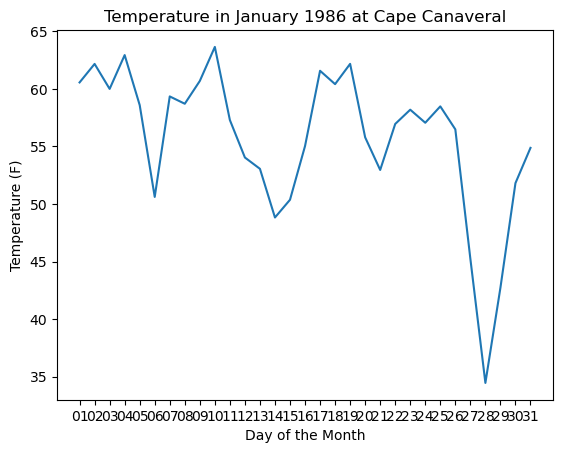

In [51]:
# Aggregate temperature data by date


# Extract the temperatures and days from the daily_temps DataFrame

# plot_vals = temperatures_jan.select("day", "temperature")
grouped_df = jan_data.groupBy("day").agg(idw(col("distance"), col("temperature")).alias("predicted_temperature")).orderBy('day')
grouped_df.show(20)

# Convert Spark DataFrame to RDD and collect data
rdd = grouped_df.rdd
days = rdd.map(lambda x: x["day"]).collect()
temps = rdd.map(lambda x: x["predicted_temperature"]).collect()

# Plot the temperatures for each day in January 1986
plt.plot(days, temps)
plt.title("Temperature in January 1986 at Cape Canaveral")
plt.xlabel("Day of the Month")
plt.ylabel("Temperature (F)")
plt.show()


